<a href="https://colab.research.google.com/github/GoranTopic/food-sales-predictions/blob/master/food_sales_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import drive to make sure it is mounted
from google.colab import drive
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use('seaborn')
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Lets mount the drive an read the data set
sales_df = pd.read_csv("/content/drive/MyDrive/CodingDojo/Stack_2/Data/sales_predictions.csv")
sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Check for nun values and zeros**

## **My Approach:**
I want to be able to replace the missing value in this data set by replaing the to the values which they show the strongest correlation to. My reasoning is that this will give me the most accurate replacement of the missing values. We might even be able to create a function which take the value of a correlated value and return the aproximate missing value.  

> First order of bussines is to take all the missing value from our data set. We can fo this by droping all the row wich contain missing values. 

In [4]:
# lets fin the number of colmns which have the missing values
sales_df.isna().any()

Item_Identifier              False
Item_Weight                   True
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

> We can see that the Columns which have missin values is just 'Item_Weight' and 'Outlet_Size'
Let's find out how many values are in those columns are NA
We also have to look out for value wich are not save as N/a

In [5]:
# get the list of columns which have a missing value
filter = sales_df.isna().any()
# get a df with only those columns
na_columns_df = sales_df.loc[:, filter]
# lets count the total number of NA value for each column
na_columns_df.isna().cumsum()

,Item_Weight,Outlet_Size
0,0,0
1,0,0
2,0,0
3,0,1
4,0,1
...,...,...
8518,1463,2409
8519,1463,2410
8520,1463,2410
8521,1463,2410


So here we cna see that `Item_Weight` column has __1463__ NA values, and the `Outlet_size` column has __2410__ NA values

In [6]:
# percentage of NA values 
print(2410 / 8525 * 100 ) # this is about %28 percent of all values
print(1463 / 8525 * 100 ) # this is about %17 percent of all values

28.269794721407628
17.161290322580644


Let remove all of the rows which have NA values 

In [7]:
clean_df = sales_df.dropna() 
# check if there is nay na value
clean_df.isna().any().any()

False

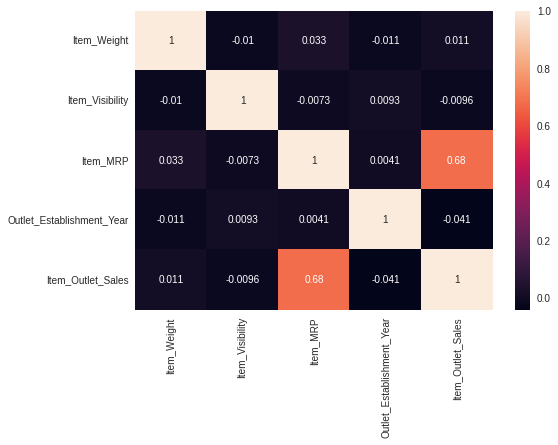

In [8]:
# lets find which value have the best correlation with the columns where we have the NA values
# can't find a the correlation between ordinal values
corr_map = clean_df.corr()
sn.heatmap(corr_map, annot=True); 

We can see that the `Item_Weight` is not really that stongly correlated with any other column. 

In [9]:
# correlation of the Items_weights
corr_map['Item_Weight'][1:].values 

array([-0.01022873,  0.03333044, -0.01059587,  0.01097183])

Let see if there is any correlation bewteen the ordinal value of `Outlet_size` and the other values 

Let see if we can graph the value other values vesus the `Outlet_Size`

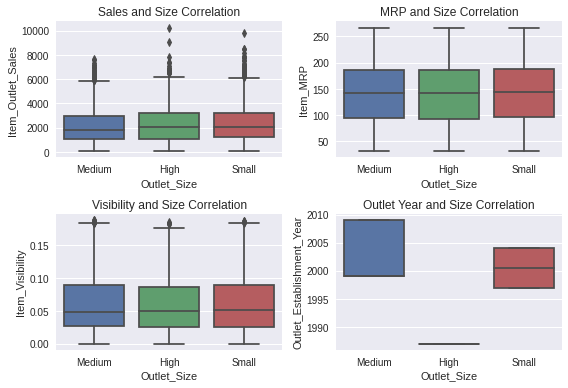

In [10]:
# so let's plot it!
# got this from
#clean_df[['Item_Outlet_Sales', 'Outlet_Size']].plot.bar(x='Outlet_Size', y='Item_Outlet_Sales');
figure, axis = plt.subplots(2, 2)
sn.boxplot(y='Item_Outlet_Sales', x='Outlet_Size', data=clean_df,ax=axis[0,0]).set(title="Sales and Size Correlation");
sn.boxplot(y='Item_MRP', x='Outlet_Size', data=clean_df,ax=axis[0,1]).set(title="MRP and Size Correlation");
sn.boxplot(y='Item_Visibility', x='Outlet_Size', data=clean_df,ax=axis[1,0]).set(title="Visibility and Size Correlation");
sn.boxplot(y='Outlet_Establishment_Year', x='Outlet_Size', data=clean_df,ax=axis[1,1]).set(title="Outlet Year and Size Correlation");
# make it all fit together
plt.tight_layout()


There does not seem to be any reall correation between the numerical value in the data set and the ordinal value of `Outlet_Size`

However there does seem to be some pattern between the `Outlet_Establisment_Year` and the `Outlet_Size`: We can see that ot only are there far more values in where the `Outlet_Size` is __Medium__ or __Small__ and that almost all the value where it is __High__ are outlets made before __1990__.

If we compare this to the distribution of `Outlest_Size` values. 

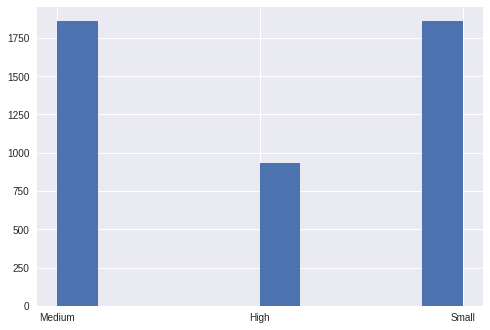

In [11]:
clean_df.Outlet_Size.hist();

We can see that ther number __high__ value is truly is significaly lower than the ther two. 

if fact only: 

In [12]:
count = len(clean_df.query('Outlet_Size == "High"'))
negative = len(clean_df.query('Outlet_Size != "High"'))
f"there are only {count} values where Outlet_Size is high, compare with {negative} values where it is not"

'there are only 932 values where Outlet_Size is high, compare with 3718 values where it is not'

In [13]:
# if face we can see that all 932 Outlets where made in the year 1987
clean_df.query('Outlet_Size == "High"').Outlet_Establishment_Year.describe()


count     932.0
mean     1987.0
std         0.0
min      1987.0
25%      1987.0
50%      1987.0
75%      1987.0
max      1987.0
Name: Outlet_Establishment_Year, dtype: float64

Thus we can safely assume that any missing value about the size of the outlet before or in __1987__ are going to be __high__, while all the values after, are going to be either __Medium__ or __Small__.

Thus let's take a look at the years of the missing values.

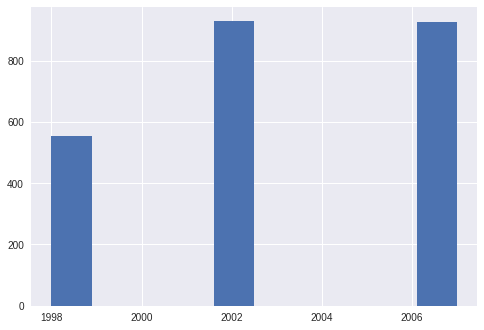

In [14]:
# get al the rows that have missing values
missing_df = sales_df[sales_df['Outlet_Size'].isna()]
missing_df.Outlet_Establishment_Year.hist();

From this graph we can see that none of the outlets which have missing values where made before or in 1987. 
Thus we can assume all of this value of `Outler_Size` can be filled with either __Small__ or __Medium__

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

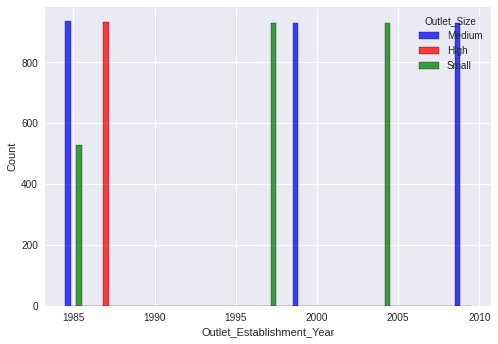

In [15]:
# 
#years = sales_df.Outlet_Establishment_Year.unique()
#sales_df.Outlet_Establishment_Year.hist(bins=100);
colors = ["blue", "red","green","black"]
sn.set_palette(sn.color_palette(colors))
sn.histplot(data=sales_df, x="Outlet_Establishment_Year", hue="Outlet_Size", bins=20, discrete=True, multiple="dodge");
#colors = ["black", "red","green","black"]
#sn.set_palette(sn.color_palette(colors))
#sn.histplot(data=missing_df, x="Outlet_Establishment_Year", bins=15)
#sn.barplot(x='Outlet_Size', hue='Outlet_Establishment_Year', data=sales_df )
sales_df.Outlet_Size.value_counts()

In [16]:
# heck the number of na values
#na_columns = super_cool_df.isna().any() # check which colmun have a na value
#g = sn.FacetGrid(data=super_cool_df, col='Outlet_Size', col_wrap=4)

#super_cool_df.loc[:, na_columns]

#add plots to grid
#g.map(sn.scatterplot, 'Outlet_Size', 'Item_Weight')


In [17]:
# fill in the Na values
#super_cool_df.fillna(method='ffill').isna().any()

# Stack 2: Data Processing

Ok, since we now ahve a target to which we are seeking to predict `Item_Outlet_Sales` we can now 'isolate' that column, the same way the world is isolating Russia. 


In [24]:
# lets make some skilearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

In [21]:
target = sales_df.Item_Outlet_Sales
features = sales_df.drop(columns='Item_Outlet_Sales')

Now let make the preprocessing object 

In [25]:
# lets split the data 
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)
# let make some imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# let's make our one hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
# Scaler
scaler = StandardScaler()
# now let's the piplines for each object 
numeric_pipe = make_pipeline(mean_imputer, scaler)
categorical_pipe = make_pipeline(freq_imputer, ohe)
# first then selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# preprocessor
preprocessor = make_column_transformer(number_tuple, category_tuple)